In [3]:
""" Example to analyze Desroziers uncertainty from file """

import os,sys
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import h5py
from datetime import datetime
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

""" Test file """
f = '/raid60/scratch/federico/DESROZIERS_MARCH2021/0-20001-0-10393_CEUAS_merged_v1.nc'
STATION = f.split('/')[-1].split('_CEUAS')[0]

F =  h5py.File(f, 'r')

def get_data(file):
    """ Simple script to extract only the most relevant data out of a netCDF file using h5py """
    f =  h5py.File(file, 'r')
    
    dfs = {}
    for v in [85, 104,105,107]:
        res = {}

        indices = f['recordindices'][str(v)]
        imin, imax = min(indices) , max(indices) # I miss here the last entr since I would need the exact index 
        
        ind_all = np.array([])
        for p in [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000]:
        #for p in [1000, 2000, ]:
            a = np.where(f['observations_table']['z_coordinate'][imin:imax] == p)[0]
            ind_all = np.append(ind_all, a)
            
        
        obs_vars = ['date_time', 'observation_value', 'observed_variable', 'z_coordinate' ]
        fb_vars  = ['biascorr@body' , 'an_depar@body', 'fg_depar@body' ]
        unc_vars = f['advanced_uncertainty'].keys()
        
        ind_all = list(ind_all)
        for c in obs_vars:
            res[c] = np.take(f['observations_table'][c][imin:imax], ind_all )
        
        for c in fb_vars:
            res[c] = np.take(f['era5fb'][c][imin:imax], ind_all )
        
        for c in unc_vars:
            res[c] = np.take(f['advanced_uncertainty'][c][imin:imax], ind_all )

        dfs[str(v)] = pd.DataFrame.from_dict(res)
        
    return dfs

res = get_data(f) # dictinary of dataframes 

#DF = pd.DataFrame.from_dict(res)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [4]:
def remove_outliers(data= '', min_p= 25, max_p= 75, cut= 1, skewed= False, only_clean = True):
        """ Finds outliers, and replace them with np.nan (to keep vector of same length)                                                                                                                                                                                              

             input ::       data = list of values 
                               min_p , max_p = minimum and maximum values of the percentile to consider to determine outliers 
                               skewed = use True to consider a skewed (not symmetricla Gaussian) distribution 
                               cut = factor to allow slight deviation from given percentiles 
             returns ::   cleaned   = list of values without outliers                                                                                                                                                                    
                               outliers   = list of outlier values                                                                                                                                                                                                               
                               lower,upper, median = outliers delimiter and median values.
            if only_clean == True, return only list of cleaned values. """
        
        q_min, q_max = np.nanpercentile(data, min_p), np.nanpercentile(data, max_p)
        cut_off = (q_max - q_min) * cut
        lower, upper = q_min-cut_off, q_max+cut_off

        if skewed==True:
            q50 = np.nanpercentile(data, 50)
            lower , upper = q_min-(q50-q_min)*cut ,  q_max+(q_max-q50)*cut  # the higher the cut, the more relaxed the contition for exclusion 

        median = np.nanmedian(data)
        cleaned, outliers = [],[]

        indices = []
        for d,ind in zip(np.asarray(data), range(len(data))):
            if d >= lower and d <= upper:
                cleaned.append(d)
                indices.append(ind)
                         
            else: # only storing non nans values 
                if not np.isnan(d):
                    outliers.append(d)

        if only_clean:
            return cleaned, indices
        else:

            return cleaned, indices, outliers, lower, upper, median

In [5]:
res['85']
print(res['85'].columns)
print(res['104'].columns)

Index(['date_time', 'observation_value', 'observed_variable', 'z_coordinate',
       'biascorr@body', 'an_depar@body', 'fg_depar@body', 'desroziers_180',
       'desroziers_30', 'desroziers_60', 'desroziers_90', 'index', 'num_180',
       'num_30', 'num_60', 'num_90'],
      dtype='object')
Index(['date_time', 'observation_value', 'observed_variable', 'z_coordinate',
       'biascorr@body', 'an_depar@body', 'fg_depar@body', 'desroziers_180',
       'desroziers_30', 'desroziers_60', 'desroziers_90', 'index', 'num_180',
       'num_30', 'num_60', 'num_90'],
      dtype='object')


In [6]:
""" Selecting a date """
DATE = '1986-08-24T12:00:00'
dt = np.datetime64(DATE)

#DF_t = DF.loc[ (DF['date_time'] == dt) ]

#a= DF.loc[ DF['observed_variable'] == 107 ][['date_time','desroziers_30','z_coordinate','num_30','observation_value']]
#print(a )

#plt.plot(DF['date_time'], DF['desroziers_30'])
#plt.show()

In [7]:
def plot_series(df_in= '', station='', vars = [], what = 'des', zoom = False):
    import matplotlib.gridspec as gridspec
    #plt.plot(DF['date_time'], DF['desroziers_30'])
    text = ''
    fs = 15 # fontsize
    dic = { 85 : {'x':'Temperature [K]'       , 'y': 'Pressure [hPa]' , 'ylim': (180,340), 'ylimdes': (0,10) } ,
            #106 : {'x': 'Wind from Direction'  , 'y': 'Pressure [hPa]', 'ylim': (180,340), 'ylimdes': (0,14) },
            107 : {'x': 'Wind Speed [m/s] '    , 'y': 'Pressure [hPa]', 'ylim': (0,100), 'ylimdes': (0,30) },
         
            104 : {'x': 'Wind u-component [m/s] '    , 'y': 'Pressure [hPa]', 'ylim': (-50,100), 'ylimdes': (0,30) },
            105 : {'x': 'Wind v-component [m/s] '    , 'y': 'Pressure [hPa]', 'ylim': (-50,100), 'ylimdes': (0,30) },

          }
    std_plevs    = [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000]
    
    
    def remove_outliers(x,y):
        return 0
    
    for v in vars:
        
        df = df_in[str(v)]
        #print(df_in)
        fig = plt.figure(figsize=(15,15), constrained_layout=True)
        fig.suptitle('Timeseries for ' + dic[v]['x'] + ' - Station ' + station, y = 0.93, fontsize = 20 )
        spec = gridspec.GridSpec(ncols=4, nrows=4)

        #df = df_in.loc[ df_in['observed_variable'] == v ]

        axs = []
        for p,num in zip(std_plevs , range(1,17) ):
            a= df.loc[ df['z_coordinate'] == p ]
            #print(a.head(n=5))
            x   = a['date_time']
            x = np.array(x)/(3600*24*365.25) + 1900
            obs = a['observation_value']
            y30 = a['desroziers_30']
            y90 = a['desroziers_90']
            y180 = a['desroziers_180']
            an = a['an_depar@body']
            fg = a['fg_depar@body']
   
            #t30 = a['num_30']

            #print(x,obs)
            axs.append(fig.add_subplot(spec[num -1]) )
            ax = axs[-1]
            
            #ax.plot([-10000],[-10000] label = 'Des. 30 [' + str(p) + ' hPa]', color = 'orange')
            ax.set_title( '[' + str(p) + ' hPa]' )
            ax.plot(x,obs, label = 'Obs', color = 'lightgray')
            if num ==1:
                ax.legend(fontsize = 9)
            #ax.grid(ls=':' , color = 'lightgray')
            #ax.set_xticks([])
            if num not in [1,5,9,13]:
                ax.set_yticks([])
                
            ax.tick_params(axis='x', rotation=45)
            
            ax2=ax.twinx()
            if what == 'des':
                ax2.plot(x,y30,  color = 'orange'    , label = 'Des. 30'  )
                ax2.plot(x,y90,  color = 'lime'      , label = 'Des. 90'  )
                ax2.plot(x,y180, color = 'slateblue' , label = 'Des. 180' )
                ax2.set_ylim(dic[v]['ylimdes'])
            else:
                ax2.plot(x,an, color = 'red', label = 'Analysis Dep.'   )
                ax2.plot(x,fg, color = 'blue', label = 'Background Dep.' )
                ax2.set_ylim((-50,50))

            if num ==1:
                ax2.legend(fontsize = 9)
            if num not in [4,8,12,16]:
                ax2.set_yticks([])
            if num in  [4,8,12,16]:
                if what == 'des':
                    ax2.set_ylabel('Uncertainty', fontsize = fs)
                else:
                    ax2.set_ylabel('Departure', fontsize = fs)

            if num in [1,5,9,13]:
                ax.set_ylabel('Observations', fontsize = fs)
                
            if num <= 12:
                ax2.set_xticks([])
            ax2.set_xlim(1950,2020 )
            if zoom:
                ax2.set_xlim(1968, 1972)
                text = 'zoom'
            ax.set_ylim(dic[v]['ylim'])

    plt.savefig('Plots/series_' + str(v) + '_' + what + '_' + text + '.png' , dpi = 150)
    plt.show()
    plt.close()
 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


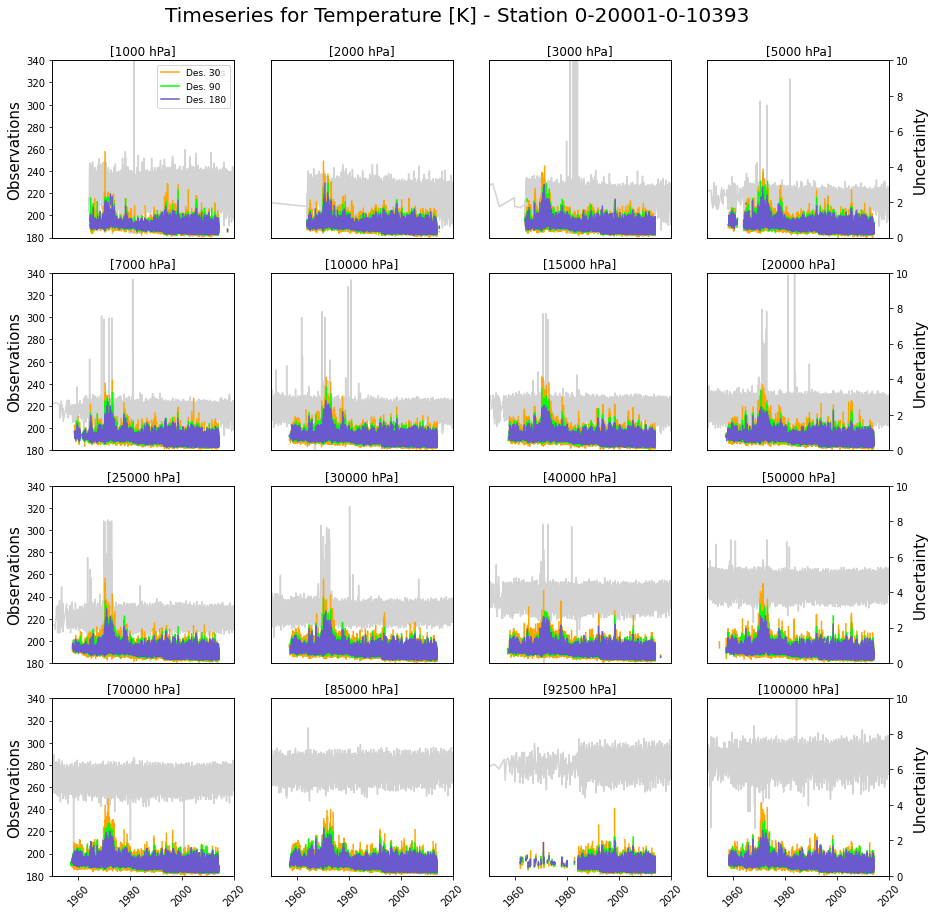

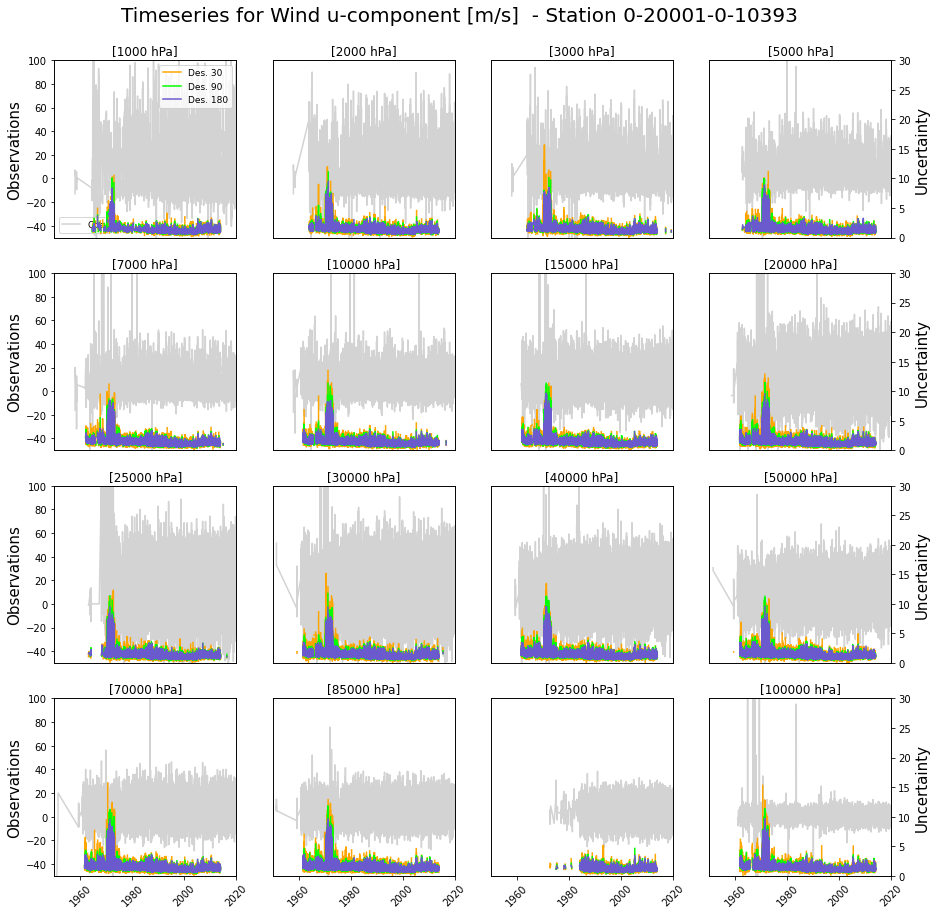

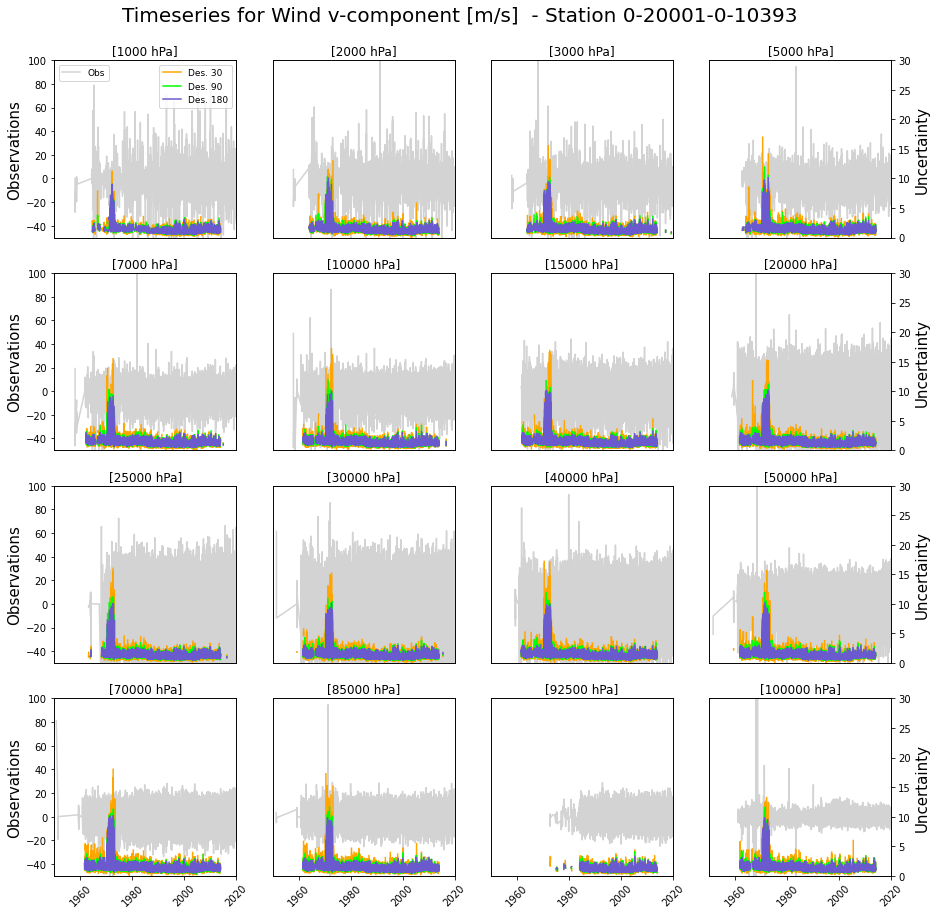

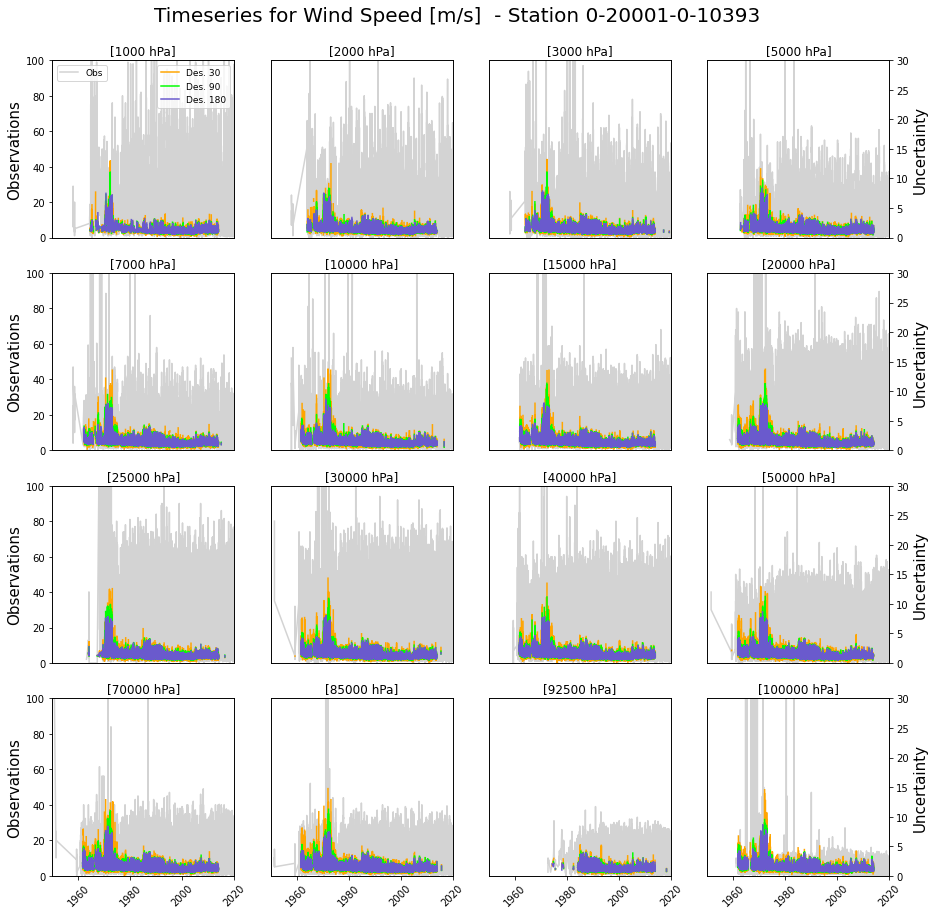

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


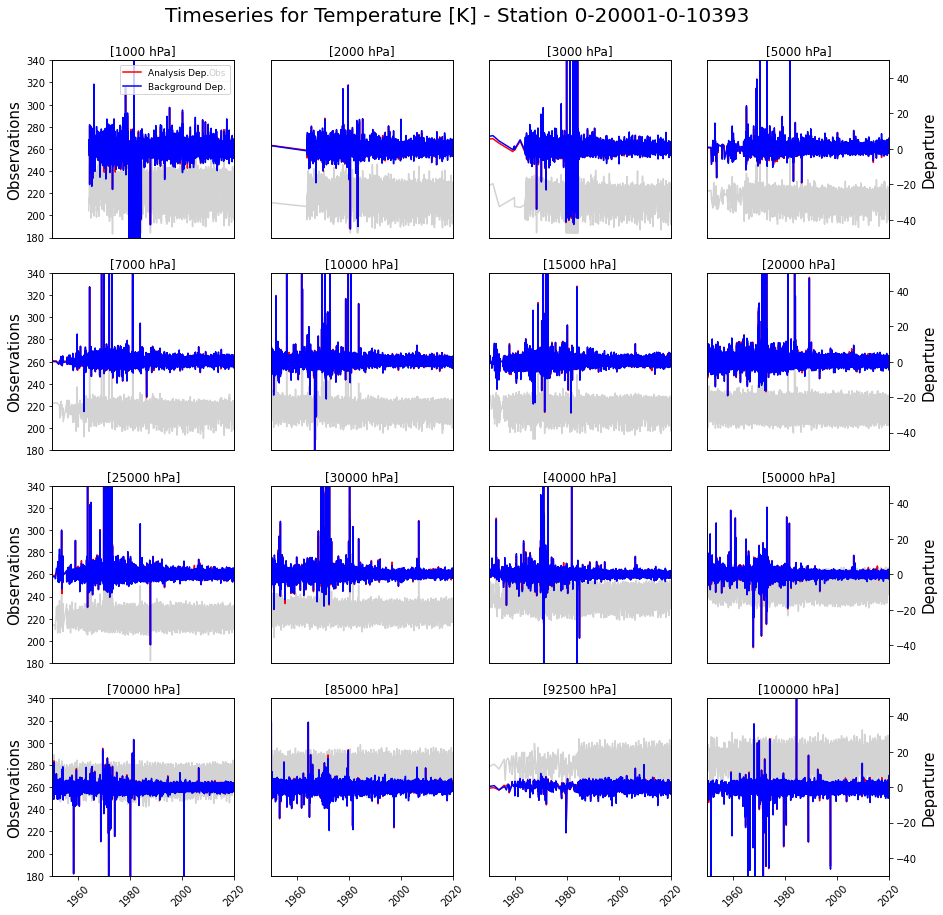

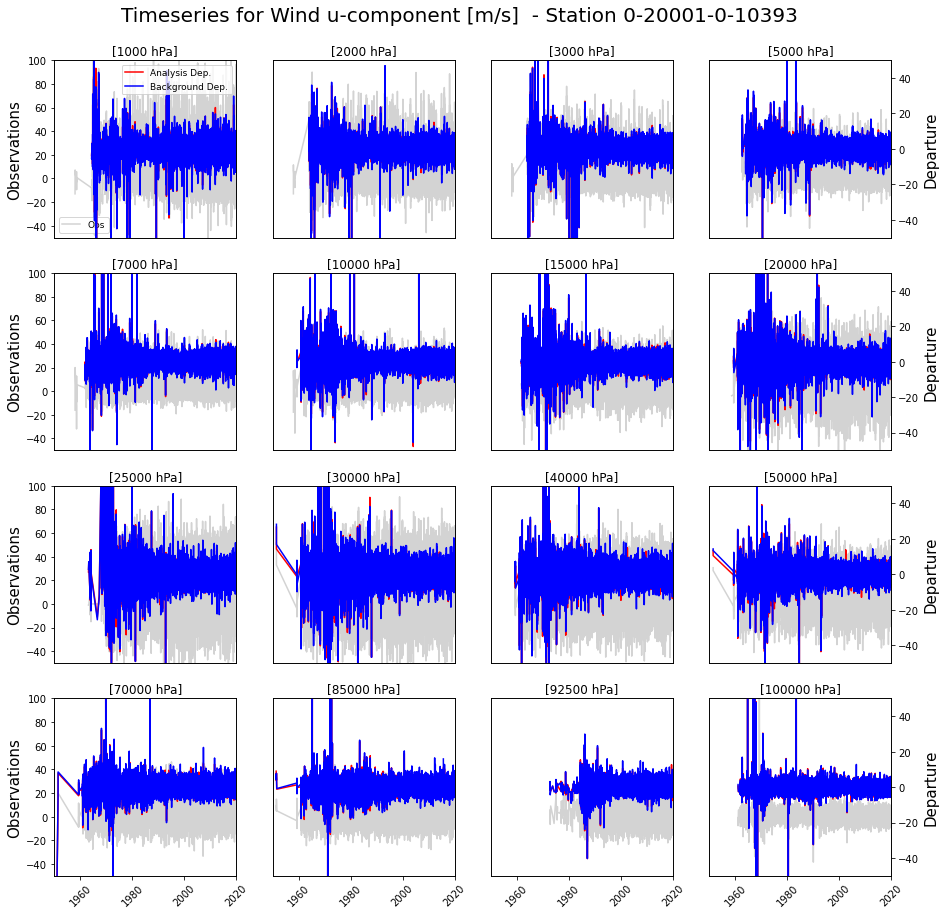

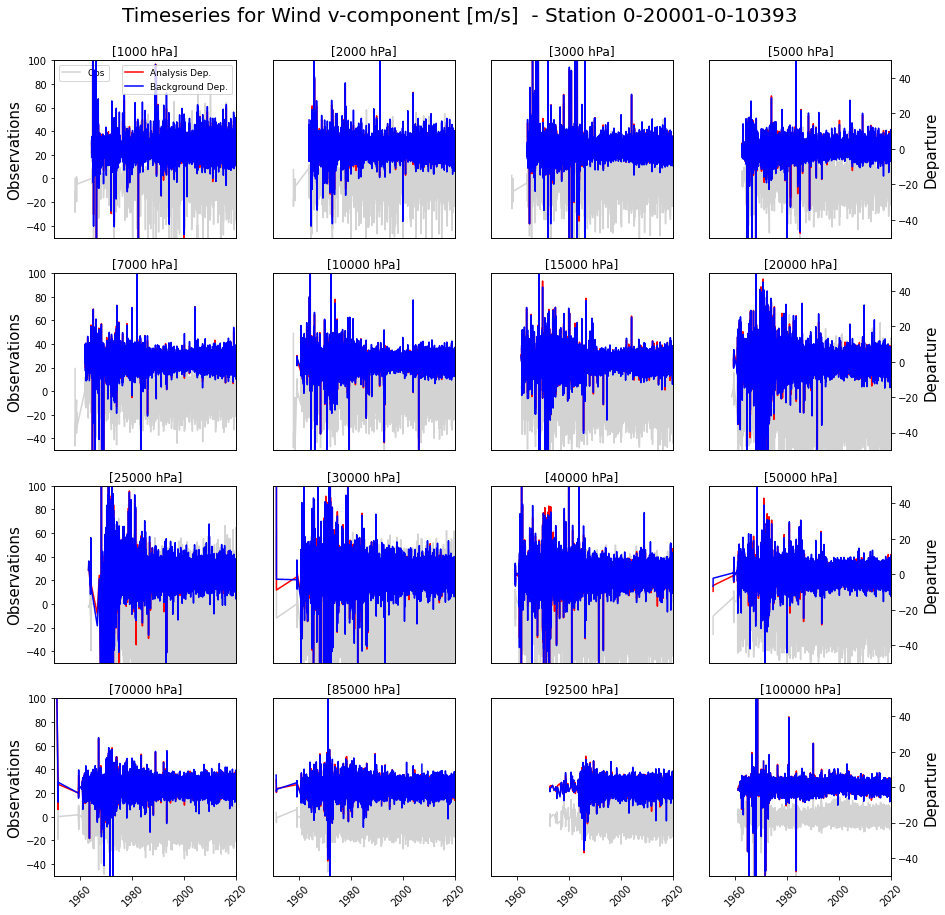

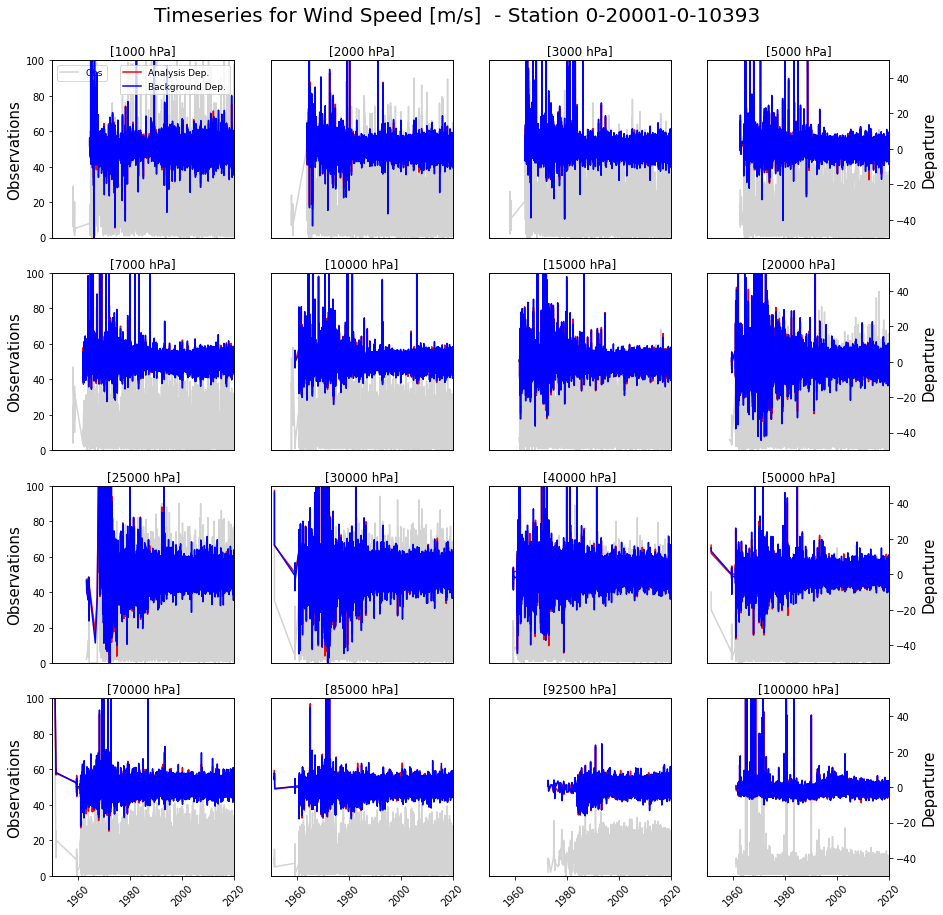

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


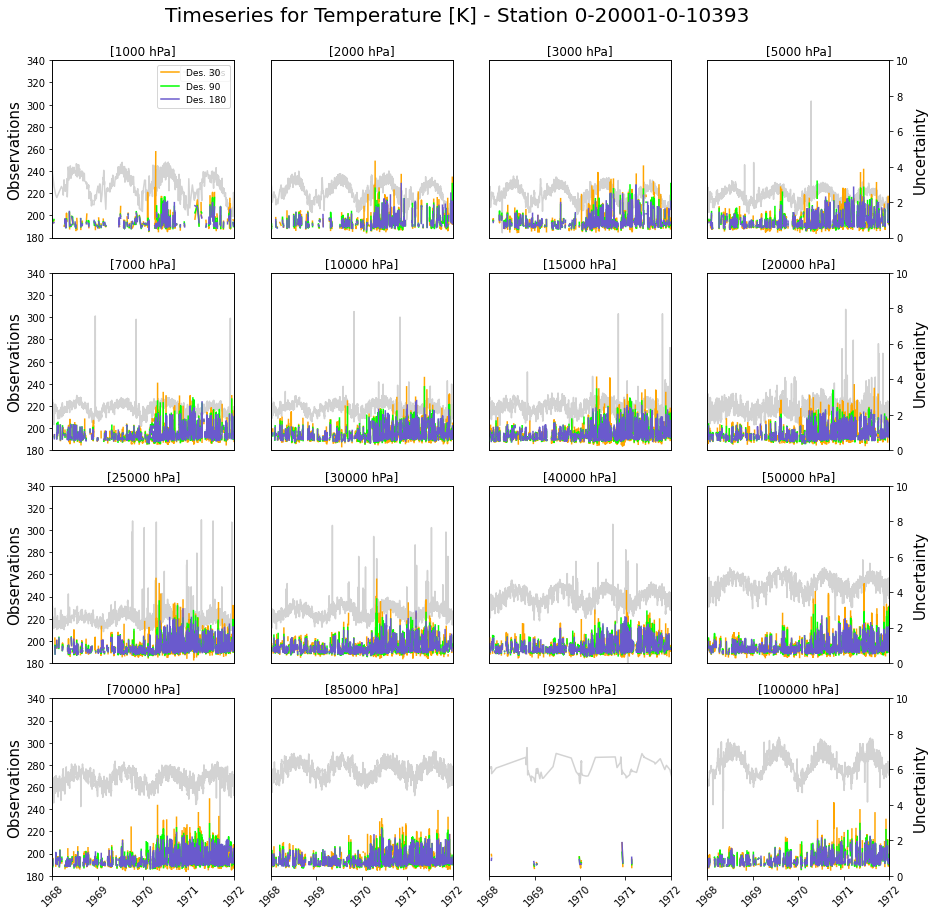

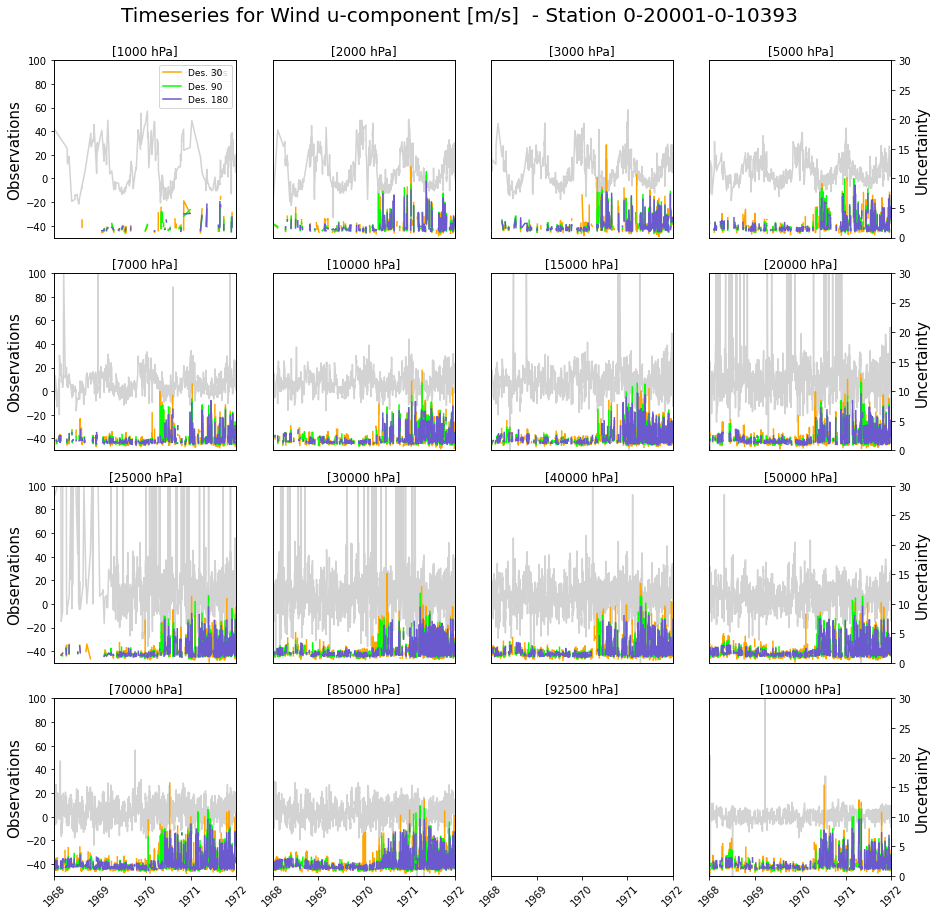

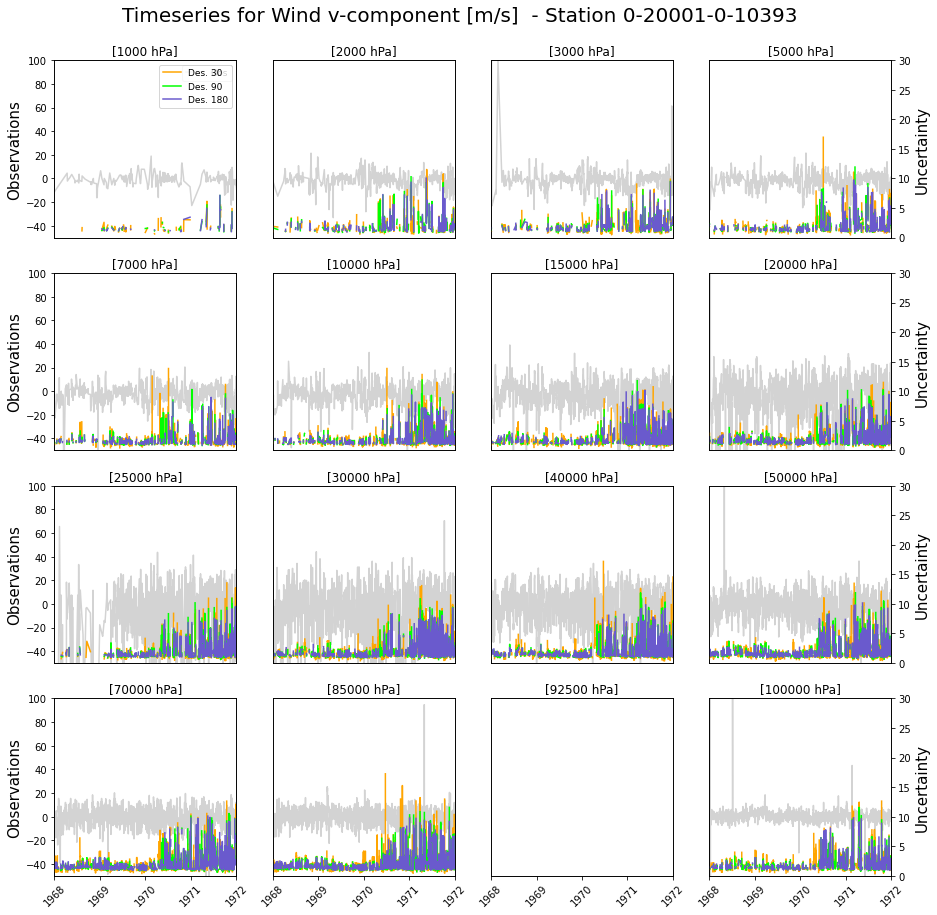

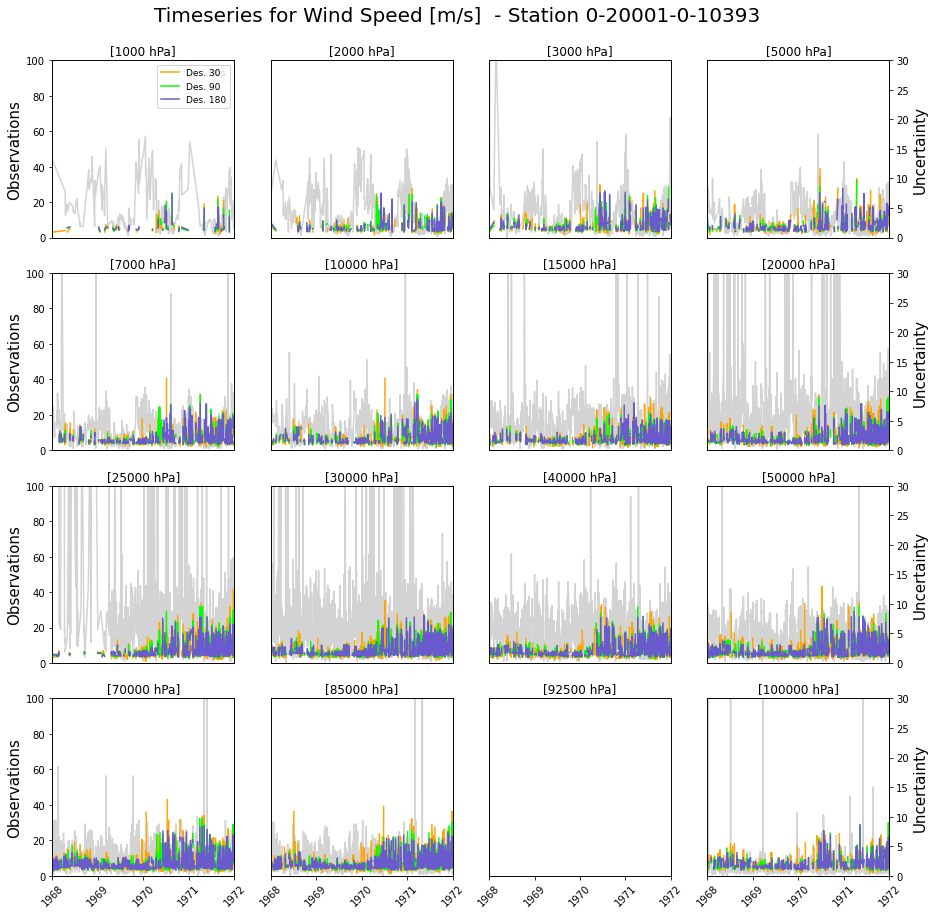

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


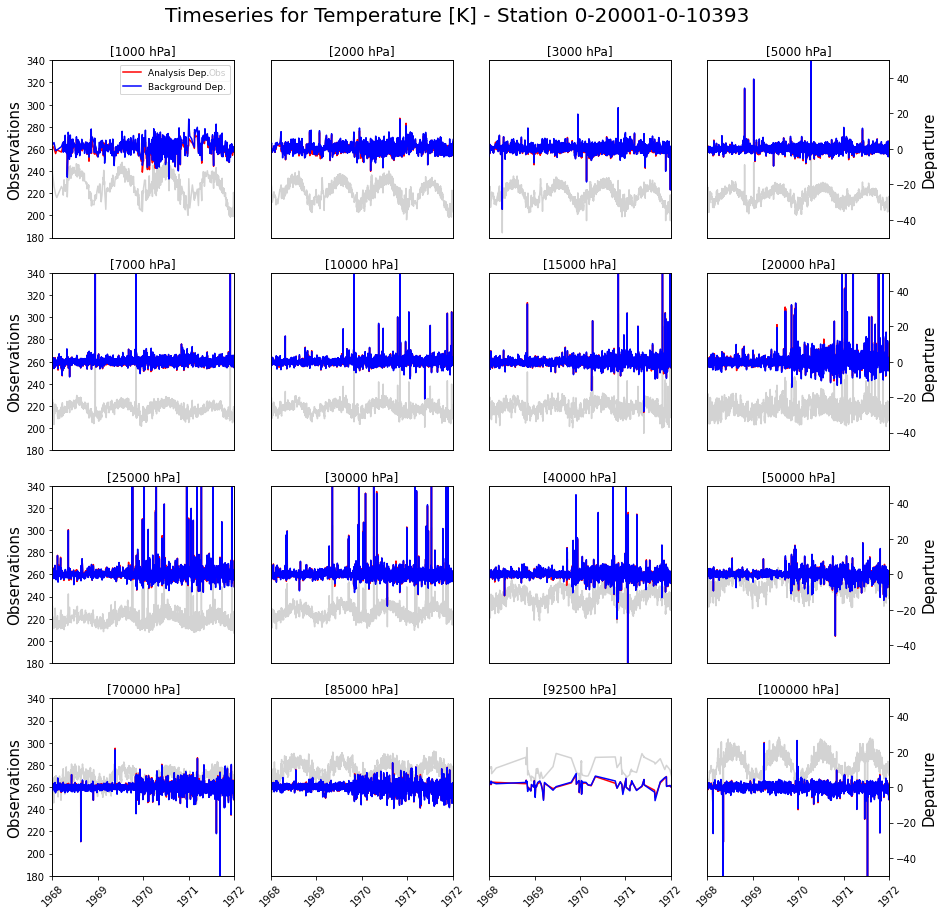

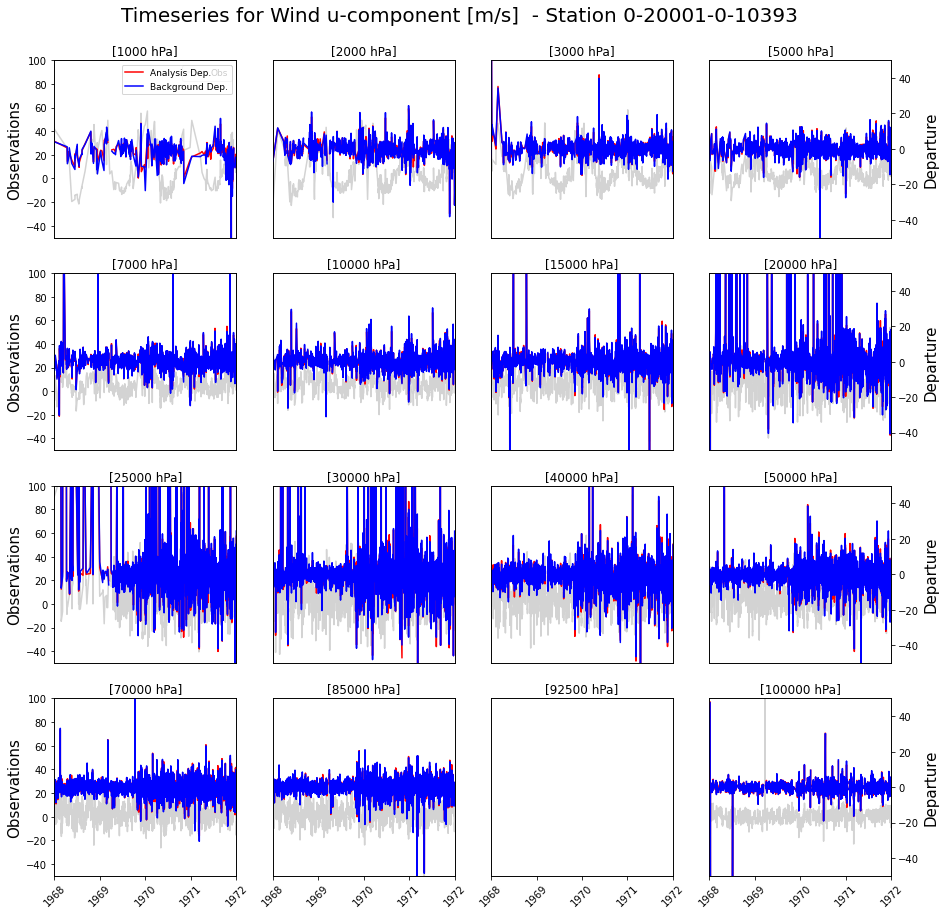

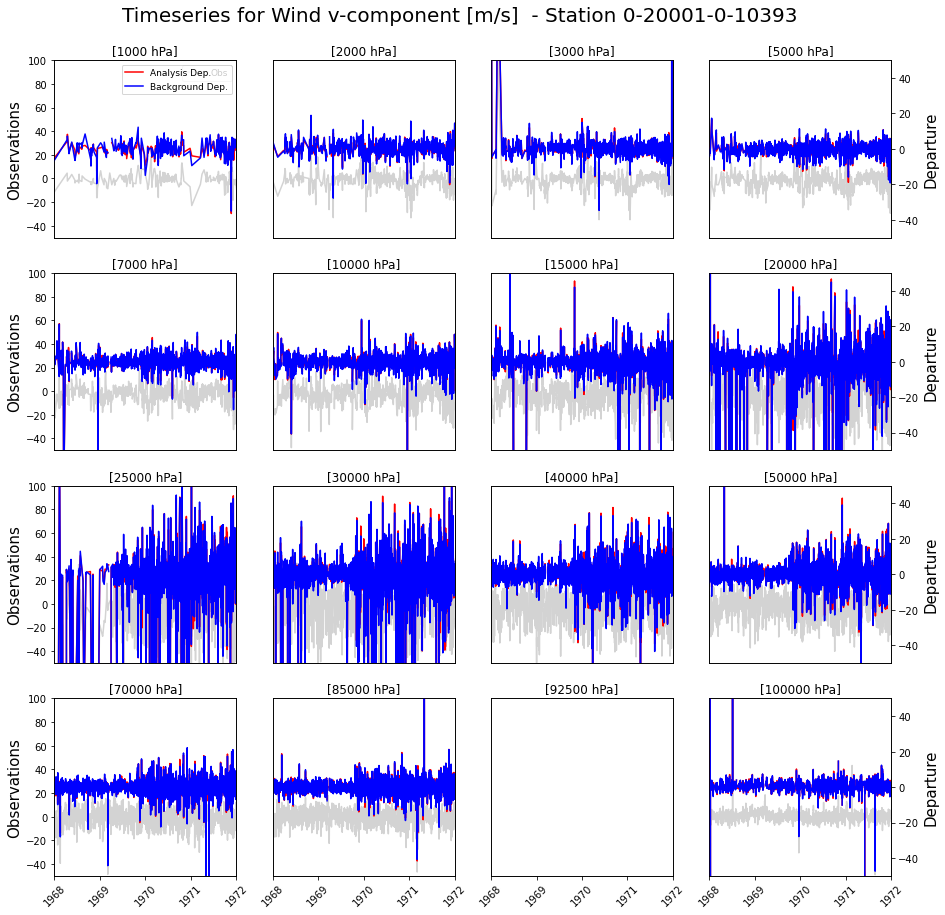

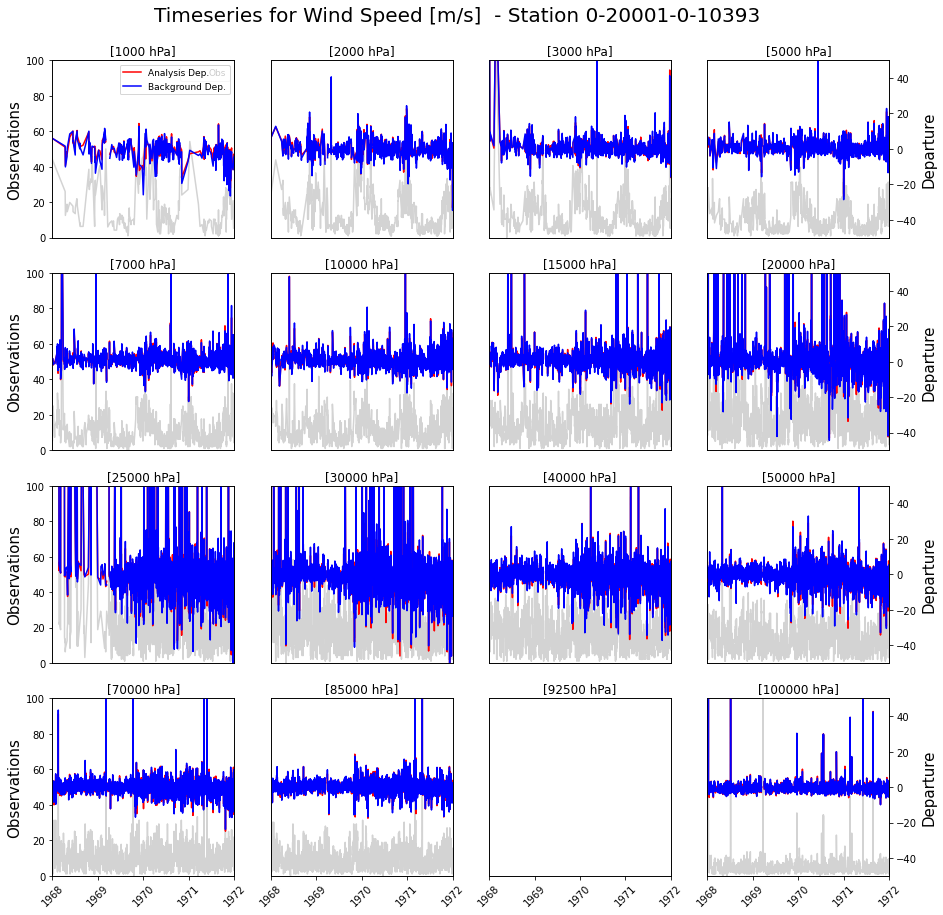

In [8]:
series = plot_series(df_in=res, station=STATION, vars = [85,104,105,107]               )
series = plot_series(df_in=res, station=STATION, vars = [85,104,105,107], what = 'dep' )
series = plot_series(df_in=res, station=STATION, vars = [85,104,105,107], zoom = True  )
series = plot_series(df_in=res, station=STATION, vars = [85,104,105,107], what = 'dep', zoom = True  )

In [31]:
def plot_profile(df_in='', date='', station='', vars = [], zoom = False ):
    
    dic = { 85 : {'x':'Temperature [K]'       , 'y': 'Pressure [hPa]'} ,
            106 : {'x': 'Wind from Direction'  , 'y': 'Pressure [hPa]'},
            107 : {'x': 'Wind Speed [m/s] '    , 'y': 'Pressure [hPa]'},
         
            104 : {'x': 'Wind u-component [m/s] '    , 'y': 'Pressure [hPa]'},
            105 : {'x': 'Wind v-component [m/s] '    , 'y': 'Pressure [hPa]'},

          }
    
    std_plevs    = [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000]
    
    dt = (date - datetime(1900,1,1,0,0)).total_seconds()

    DATE = date.strftime('%Y%m%d%h%m')


    for v in vars:
        df = df_in[str(v)]
        
        """ Selecting the variable temperature """
        dt = 3818011506
        indices = np.where (df['date_time'][:]== dt)[0]
        #print(indices)
        #print(df['date_time'].values[-1])
        df = df.iloc[indices]
        #print(df)
        #print(df[['date_time','desroziers_30','z_coordinate']])
        temp, bias, press, adj = [], [], [], []
        des_30, des_60, des_90, des_180 = [], [], [], []
        des_30_p, des_30_m = [], []
        des_60_p, des_60_m = [], []
        des_90_p, des_90_m = [], []
        des_180_p, des_180_m = [], []

        for p in std_plevs:
            ind = np.where ( df['z_coordinate'] == p )[0]
            print(ind)
            if len(ind) > 0:

                t = df['observation_value'][ind].values[0]
                b = df['biascorr@body'][ind].values[0]
                d30 = df['desroziers_30'][ind].values[0]
                d60 = df['desroziers_60'][ind].values[0]
                d90 = df['desroziers_90'][ind].values[0]
                d180 = df['desroziers_180'][ind].values[0]

                if v != 85:
                    b = 0
                    
                if not np.isnan(t) and not np.isnan(b) and not np.isnan(d30):
                    temp.append(t )
                    bias.append(b)
                    des_30.append(d30)
                    des_60.append(d60)
                    des_90.append(d90)
                    des_180.append(d180)
                    
                    press.append(p/100)
                    a = t-b
                    adj.append(a)
                    des_30_m.append(a - d30/2)
                    des_30_p.append(a + d30/2)

                    des_60_m.append(a - d60/2)
                    des_60_p.append(a + d60/2)
                    
                    des_90_m.append(a - d90/2)
                    des_90_p.append(a + d90/2)
                    
                    des_180_m.append(a - d180/2)
                    des_180_p.append(a + d180/2)

        obs_all = df['observation_value'].values
        p_all = df['z_coordinate'].values/100
        
        fs = 20
        fig, ax1= plt.subplots(figsize=(12,10) )        

        fig.suptitle('Station ' + station + ' - Profile '  + DATE , y = 0.94, fontsize = fs)

        ax1.tick_params(axis='both', which='major', labelsize=15)
        ax1.tick_params(axis='both', which='minor', labelsize=8)
        w = ax1.invert_yaxis() 

        """ Adding error band """
        #print(press, des_30_m, des_30_p)
        
        ax1.fill_betweenx(press, des_30_m, des_30_p, color = 'blue', alpha = 0.2)    
        #ax1.fill_betweenx(press, des_60_m, des_60_p, color = 'lime', alpha = 0.2)    
        ax1.fill_betweenx(press, des_90_m, des_90_p, color = 'lime', alpha = 0.2)    
        ax1.fill_betweenx(press, des_180_m, des_180_p, color = 'red', alpha = 0.2)    
        
        ax1.plot(adj, press , label = 'Desroziers 30' , color = 'blue' , alpha = 0.2  )
        ax1.plot(adj, press , label = 'Desroziers 60' , color = 'lime' , alpha = 0.2  )
        ax1.plot(adj, press , label = 'Desroziers 180' , color = 'red' , alpha = 0.2  )

        
        ax1.set_ylabel( dic[v]['y'] , fontsize = fs )     
        ax1.set_xlabel( dic[v]['x'] , fontsize = fs )          

        #print(obs_all, p_all)
        ax1.scatter(obs_all, p_all, color = 'gray' , label = 'All Observations' )

        ax1.scatter(temp, press, color = 'red'   , label = 'Observation' )
        ax1.scatter(adj, press, color = 'orange' , label = 'Adjusted Obs.' )
        

        
        ax1.grid(ls =":" , color = "lightgray")
        ax1.legend(fontsize = fs)
        
        os.system('mkdir Plots')
        
        if v == 85 and zoom:
            ax1.set_xlim (190,250)
            plt.savefig('Plots/Desrozier_profile_' + DATE + '_zoom_' + str(v) + '.png', dpi = 150 )
        else:
            plt.savefig('Plots/Desrozier_profile_' + DATE + '_' + str(v) + '.png', dpi = 150 )

        plt.show()
        plt.close(9)
    
  

In [32]:
""" Convert to datetime in seconds adter 1900-01-01-00:00"""
t = datetime(2018,12,1,12,0)



profile = plot_profile(df_in=res, date=t, station=STATION, vars = [85, 104,105,107], zoom = False )

[  41567   97544  160083  228484  299112  380204  460598  547356  625172
  713613  799075  888643  986398 1092334 1164318 1224747]
3818011506


KeyError: "None of [Int64Index([0], dtype='int64')] are in the [index]"